### Load Libraries

In [184]:
import pandas as pd
import numpy as np
import string
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


### Define Global Functions

In [190]:
def print_results(cv_h, show_all = False):
    """Print out results of the hyperparameter optimization"""
    print('Best:')
    print(round(cv_h.best_score_, 3), ' for ', cv_h.best_params_)
    if show_all:
        print('All:')
        for mean, params in zip(cv_h.cv_results_['mean_test_score'], 
                                cv_h.cv_results_['params']):
                print('{}  for {}'.format(round(mean, 3), params))

In [192]:
def make_song_df(path):
    """ Build a data frame from all the text files which consist in path """
    corpus = []
    artists_name = []
    songs_name = []
    folders = [name for name in os.listdir(path) if ( name[0] != '.' )]
    for folder in folders:
        files = os.listdir(f'{path}/{folder}')
        print(f'{len(files)} unique lyrics from {folder} have been added to datafram.')
        for file in files:
            if file[0] != '.':
                continue
            if os.path.isfile(f'{path}/{folder}/{file}'):

                song_name = os.path.splitext(file)[0]
                song_name = song_name.replace('_', ' ')
                songs_name.append(song_name)
                artists_name.append(folder)
                lyric = open(file=f'{path}/{folder}/{file}',mode='r').read()
                corpus.append(lyric)
            else:
                continue
    dict = {'artist_name': artists_name, 'song_name': songs_name, 'lyric': corpus} 
    df = pd.DataFrame(dict)
    return df

In [193]:
def print_evaluation_metrics(model,X_train,y_train,X_test,y_test):
    
    """ Print out some evaluation metrics """
    
    print(f'train score: {round(model.score(X_train,y_train),2)}')
    print(f'test score: {round(model.score(X_test,y_test),2)}')

In [194]:
# save evaluation metrics using cross validation
def save_evaluation_metrics(classifier,classifier_name, summary, X, y):
    
    AUC = round(cross_val_score(classifier, X, y, cv = 2, scoring='roc_auc_ovr_weighted').mean(),2)
    accuracy = round(cross_val_score(classifier, X, y, cv = 2, scoring='accuracy').mean(),2)
    precision = round(cross_val_score(classifier, X, y, cv = 2, scoring='precision_weighted').mean(),2)
    recall = round(cross_val_score(classifier, X, y, cv = 2, scoring='recall_weighted').mean(),2)
    f1 = round(cross_val_score(classifier, X, y, cv = 2, scoring='f1_weighted').mean(),2)
    
    summary['Classifier Name'].append(classifier_name)
    summary['AUC'].append(AUC)
    summary['Accuracy'].append(accuracy)
    summary['Precision'].append(precision)
    summary['Recall'].append(recall)
    summary['F1'].append(f1)
    
    
    return summary

### Load Data

In [31]:
# build a dataframe from lyrics files
df = make_song_df(path='../data/')
df

155 unique lyrics from metallica have been added to datafram.
181 unique lyrics from coldplay have been added to datafram.
158 unique lyrics from rihanna have been added to datafram.
64 unique lyrics from billieeilish have been added to datafram.


,artist_name,song_name,lyric
0,billieeilish,.txt,\n\nMy Invisalign has finally...\nI have taken...


### Exploratory Data Analysis

### Logistic Regression

In [4]:
# define features and target
X = df['lyric']
y = df['artist_name']

In [5]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((446,), (112,))

#### Define Preprocessing Pipeline

In [6]:
# define tekonizer function
def my_tokenizer(text):
    table = str.maketrans('','',string.punctuation)
    # split the text into separate words
    text = text.split()
    #remove punctuations
    text = [word.translate(table) for word in text]
    #remove words which are less than two character e.g. 's and a
    text = [word for word in text if(len(word)>2)]
    #remove words which include of numbers
    text = [word for word in text if(word.isalpha())]
    return text

In [131]:
# define pipeline for preprocessing (equivalent with using TfidfVectorizer)
preprocessor = Pipeline([
    ('cv', CountVectorizer(lowercase=True,max_df=0.50,tokenizer=my_tokenizer)),
    ('tf', TfidfTransformer())   
])

In [132]:
# take a look at X after preprocessing
matrix = preprocessor.fit_transform(X_train)
tfdf = pd.DataFrame(matrix.todense(), columns=preprocessor['cv'].get_feature_names())
tfdf.describe()

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaaayy,abducts,abel,abide,able,abnormal,about,above,absolute,absolutely,...,yuh,yum,yummy,yup,yyou,zero,zeros,ziploc,zonday,zone
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,...,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,0.000141,0.000141,0.000097,0.000368,0.000361,0.000264,0.009946,0.001776,0.000240,0.000281,...,0.000640,0.000048,0.000048,0.000352,0.000398,0.000407,0.000260,0.000068,0.000076,0.000215
std,0.002981,0.002985,0.002052,0.007770,0.005522,0.005582,0.034874,0.016179,0.005062,0.004205,...,0.012791,0.001016,0.001016,0.005759,0.008397,0.005015,0.005501,0.001436,0.001615,0.004541
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.062961,0.063046,0.043328,0.164101,0.098913,0.117889,0.286902,0.265146,0.106901,0.067242,...,0.269727,0.021461,0.021461,0.113652,0.177336,0.069412,0.116166,0.030332,0.034111,0.095910


In [134]:
# print out the stop words
preprocessor['cv'].stop_words_

{'all', 'and', 'but', 'for', 'just', 'that', 'the', 'you', 'your'}

#### Create Classifier

In [171]:
lr = Pipeline([
    ('preprocessor', preprocessor),
    ('m_lr', LogisticRegression(max_iter=1000,C=1.5))    
])

In [172]:
lr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cv',
                                  CountVectorizer(max_df=0.5,
                                                  tokenizer=<function my_tokenizer at 0x7f9d2094b5e0>)),
                                 ('tf', TfidfTransformer())])),
                ('m_lr', LogisticRegression(C=1.5, max_iter=1000))])

#### Tune Hyperparameters

In [177]:
# get list of hyperparameters
lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'm_lr', 'preprocessor__memory', 'preprocessor__steps', 'preprocessor__verbose', 'preprocessor__cv', 'preprocessor__tf', 'preprocessor__cv__analyzer', 'preprocessor__cv__binary', 'preprocessor__cv__decode_error', 'preprocessor__cv__dtype', 'preprocessor__cv__encoding', 'preprocessor__cv__input', 'preprocessor__cv__lowercase', 'preprocessor__cv__max_df', 'preprocessor__cv__max_features', 'preprocessor__cv__min_df', 'preprocessor__cv__ngram_range', 'preprocessor__cv__preprocessor', 'preprocessor__cv__stop_words', 'preprocessor__cv__strip_accents', 'preprocessor__cv__token_pattern', 'preprocessor__cv__tokenizer', 'preprocessor__cv__vocabulary', 'preprocessor__tf__norm', 'preprocessor__tf__smooth_idf', 'preprocessor__tf__sublinear_tf', 'preprocessor__tf__use_idf', 'm_lr__C', 'm_lr__class_weight', 'm_lr__dual', 'm_lr__fit_intercept', 'm_lr__intercept_scaling', 'm_lr__l1_ratio', 'm_lr__max_iter', 'm_lr__multi_class', 'm_lr__n_jobs', 'm_

In [197]:
parameters = {'m_lr__C': np.arange(1e-2,10,0.1)}

In [200]:
np.arange(0.1,10,0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

In [188]:
cv_h =  GridSearchCV(estimator=lr,param_grid=parameters,cv=5,n_jobs=-1)

In [189]:
cv_h.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('cv',
                                                         CountVectorizer(max_df=0.5,
                                                                         tokenizer=<function my_tokenizer at 0x7f9d2094b5e0>)),
                                                        ('tf',
                                                         TfidfTransformer())])),
                                       ('m_lr',
                                        LogisticRegression(C=1.5,
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'m_lr__C': array([1.000e-02, 1.010e+00, 2.010e+00, 3.010e+00, 4.010e+00, 5.010e+00,
       6.010e+00, 7...
       1.201e+01, 1.301e+01, 1.401e+01, 1.501e+01, 1.601e+01, 1.701e+01,
       1.801e+01, 1.901e+01, 2.001e+01, 2.101e+01, 2.201e+01, 2.301e+01,
       2.401e+01, 2.501e+01, 2.601e+01, 2.701e+01, 2.801e+01, 2.901e+01,
       3.001e+01, 3.101e+01, 3.201e+01, 3.301e+01, 3.401e+01, 3.501e+01,
       3.601e+01, 3.701e+01, 3.801e+01, 3.901e+01, 4.001e+01, 4.101e+01,
       4.201e+01, 4.301e+01, 4.401e+01, 4.501e+01, 4.601e+01, 4.701e+01,
       4.801e+01, 4.901e+01])})

In [195]:
# Print results of hyperparameter optimization using random search       
print_results(cv_h, show_all=False)

Best:
0.731  for  {'m_lr__C': 6.01}


In [201]:
# Extract best model
lr_best = cv_h.best_estimator_
lr_best

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cv',
                                  CountVectorizer(max_df=0.5,
                                                  tokenizer=<function my_tokenizer at 0x7f9d2094b5e0>)),
                                 ('tf', TfidfTransformer())])),
                ('m_lr', LogisticRegression(C=6.01, max_iter=1000))])

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


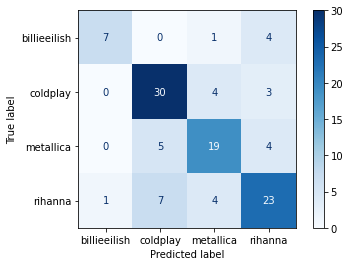

In [202]:
# plot confusion matrix
metrics.plot_confusion_matrix(lr_best, X_test, y_test,
                              values_format=".4g", 
                              cmap='Blues'
                             );

In [203]:
print_evaluation_metrics(lr_best,X_train,y_train,X_test,y_test)

train score: 1.0
test score: 0.71


In [120]:
summary = {'Classifier Name':[],'AUC':[],'Accuracy':[]
           ,'Precision':[],'Recall':[],'F1':[]}

summary = save_evaluation_metrics(lr,'Logistic Regression',summary,X,y)
summary

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Classifier Name': ['Logistic Regression'],
 'AUC': [0.86],
 'Accuracy': [0.51],
 'Precision': [0.59],
 'Recall': [0.51],
 'F1': [0.42]}

In [ ]:
# Hyper